# Bayes Rule

Bayes' rule arises when you want to make statements about an unknown quantity (e.g., a parameter, hypothesis, or event) given everything you know about a specific situation (data and generative model for the data) so you can **condition on all the knowns and treat the unknown as distributions**, scaled by the overall likelihood of data to calibrate.

# Graphical Summary

![Fig](./graphical_summary/slides/Slide23.png)

# Key Formula

Bayes' rule provides the foundation for updating our beliefs about parameters based on observed data. It tells us how to compute the posterior probability of a parameter $\theta$ given data $\text{D}$ by combining the likelihood of the data with our prior beliefs:

$$
P(\theta|\text{D}) = \frac{P(\text{D}|\theta) \times P(\theta)} {P(\text{D})}
$$

where:
- $P(\theta|\text{D})$ is the **posterior** – probability of parameter $\theta$ given data $\text{D}$
- $P(\text{D}|\theta)$ is the **likelihood** – probability of observing data $\text{D}$ given parameter $\theta$
- $P(\theta)$ is the **prior** – initial belief about parameter $\theta$ before seeing data
- $P(\text{D})$ is the **evidence** (or marginal likelihood) – total probability of observing data $\text{D}$

# Technical Details

## Core Principle
Bayes' rule updates prior beliefs with observed evidence to obtain posterior probabilities. Unlike frequentist approaches that treat parameters as fixed unknowns, Bayesian inference treats parameters as random variables, enabling direct probabilistic statements about them.

**The Denominator (Evidence):**
The evidence $P(\text{D})$ acts as a normalizing constant:

$$
P(\text{D}) = \int P(\text{D}|\theta) P(\theta) \, d\theta
$$

This marginal likelihood is often intractable to compute directly, motivating approximation methods like Markov Chain Monte Carlo (MCMC) or variational inference.

## Conjugate Priors

When the prior and posterior belong to the same distributional family, we call the prior **conjugate**. Conjugate priors yield closed-form posterior distributions, simplifying computation. Common examples include:
- Beta prior with binomial likelihood → Beta posterior
- Normal prior with normal likelihood → Normal posterior
- Dirichlet prior with multinomial likelihood → Dirichlet posterior

## Applications in Statistical Genetics

- Estimate the probability a genetic variant affects a trait given observed association data
- Incorporate functional annotations as informative priors in fine-mapping studies
- Prioritize causal variants among correlated candidates in linkage disequilibrium regions
- Model genotype uncertainty in low-coverage sequencing data

# Related Topics

- [ordinary least squares](https://statfungen.github.io/statgen-primer/ordinary_least_squares.html)
- [summary statistics](https://statfungen.github.io/statgen-primer/summary_statistics.html)
- [likelihood](https://statfungen.github.io/statgen-primer/likelihood.html)

# Example

In our previous [Lecture: likelihood](https://statfungen.github.io/statgen-primer/likelihood.html) analysis, we found that among three models ($\beta = 0$, $\beta = 0.5$, $\beta = 1.0$), the data supported Model 2, $\beta = 0.5$ most strongly. In [Lecture: maximum likelihood estimation](https://statfungen.github.io/statgen-primer/maximum_likelihood_estimation.html), we addressed this by finding $\hat{\theta}_\text{MLE}$. But what if we had prior beliefs about which model was more plausible before seeing the data?

For example, from previous studies we might believe large genetic effects ($\beta = 1.0$) are rare, while small or no effects are more common. How do we **combine prior knowledge with observed data to get updated beliefs**?

Bayes' rule provides the formal framework: start with prior probabilities for each model, multiply by the likelihood, and obtain posterior probabilities representing updated beliefs after seeing the data.

(For simplicity we work with three discrete models, but the same principle applies when $\beta$ follows a continuous distribution, as in [Lecture: Bayes factor](https://statfungen.github.io/statgen-primer/Bayes_factor.html).)

## Setup

In [1]:
# Clear the environment
rm(list = ls())
library(ggplot2)
library(dplyr)
set.seed(19)  # For reproducibility

# Generate genotype data for 5 individuals at 1 variant
N <- 5
genotypes <- c("CC", "CT", "TT", "CT", "CC")  # Individual genotypes
names(genotypes) <- paste("Individual", 1:N)

# Define alternative allele
alt_allele <- "T"

# Convert to additive genotype coding (count of alternative alleles)
Xraw_additive <- numeric(N)
for (i in 1:N) {
  alleles <- strsplit(genotypes[i], "")[[1]]
  Xraw_additive[i] <- sum(alleles == alt_allele)
}
names(Xraw_additive) <- names(genotypes)

# Standardize genotypes
X <- scale(Xraw_additive, center = TRUE, scale = TRUE)[,1]

# Set true beta and generate phenotype data
true_beta <- 0.4
true_sd <- 1.0

# Generate phenotype with true effect
Y <- X * true_beta + rnorm(N, 0, true_sd)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Likelihood and Log-likelihood

In [2]:
# Likelihood function for normal distribution
likelihood <- function(beta, sd, X, Y) {
  mu <- X * beta
  prod(dnorm(Y, mean = mu, sd = sd, log = FALSE))
}

# Log-likelihood function (more numerically stable)
log_likelihood <- function(beta, sd, X, Y) {
  mu <- X * beta
  sum(dnorm(Y, mean = mu, sd = sd, log = TRUE))
}

In [3]:
# Test three different models with different beta values
beta_values <- c(0, 0.5, 1.0)  # Three different effect sizes to test
model_names <- paste0("Model ", 1:3, "\n(beta = ", beta_values, ")")

# Calculate likelihoods and log-likelihoods
results <- data.frame(
  Model = model_names,
  Beta = beta_values,
  Likelihood = numeric(3),
  Log_Likelihood = numeric(3)
)

for (i in 1:3) {
  results$Likelihood[i] <- likelihood(beta = beta_values[i], sd = true_sd, X = X, Y = Y)
  results$Log_Likelihood[i] <- log_likelihood(beta = beta_values[i], sd = true_sd, X = X, Y = Y)
}

In [4]:
results

Model,Beta,Likelihood,Log_Likelihood
<chr>,<dbl>,<dbl>,<dbl>
Model 1 (beta = 0),0.0,0.0019210299,-6.254894
Model 2 (beta = 0.5),0.5,0.0021961524,-6.121048
Model 3 (beta = 1),1.0,0.0009236263,-6.987203


## Setting Prior Beliefs

Now let's specify our prior beliefs about each model. Suppose based on protein quantitative trait loci (pQTL) analysis results, we have the following prior beliefs:

* **Model 1** ($\beta = 0$): Prior probability = 0.2. No genetic effect is less likely, as pQTL studies typically identify variants with measurable effects on protein levels.
* **Model 2** ($\beta = 0.5$): Prior probability = 0.4. Moderate effects are most commonly observed in pQTL studies, receiving the highest prior probability.
* **Model 3** ($\beta = 1.0$): Prior probability = 0.4. Substantial effects are also plausible in pQTL studies, where cis-acting variants can have strong regulatory impacts.

These priors sum to 1.0, representing mutually exclusive hypotheses that exhaust all possibilities under consideration.

In [5]:
# Prior probabilities
priors <- c(0.2, 0.4, 0.4)

## Applying Bayes' Rule

In [6]:
# Extract likelihood values from our previous analysis
likelihoods <- results$Likelihood

# Calculate the evidence P(D) = sum of (likelihood × prior) for all models
evidence <- sum(likelihoods * priors)

# Calculate posterior for each model using Bayes' rule
posteriors <- (likelihoods * priors) / evidence

# Create summary table
Bayes_table <- data.frame(
  Model = paste0("Model ", 1:3, "\n(beta = ", beta_values, ")"),
  Prior = priors,
  Likelihood = likelihoods,
  Posterior = posteriors
)


The prior, likelihood and posterior for each model is:

In [7]:
Bayes_table

Model,Prior,Likelihood,Posterior
<chr>,<dbl>,<dbl>,<dbl>
Model 1 (beta = 0),0.2,0.0019210299,0.2354034
Model 2 (beta = 0.5),0.4,0.0021961524,0.5382339
Model 3 (beta = 1),0.4,0.0009236263,0.2263627


## Results

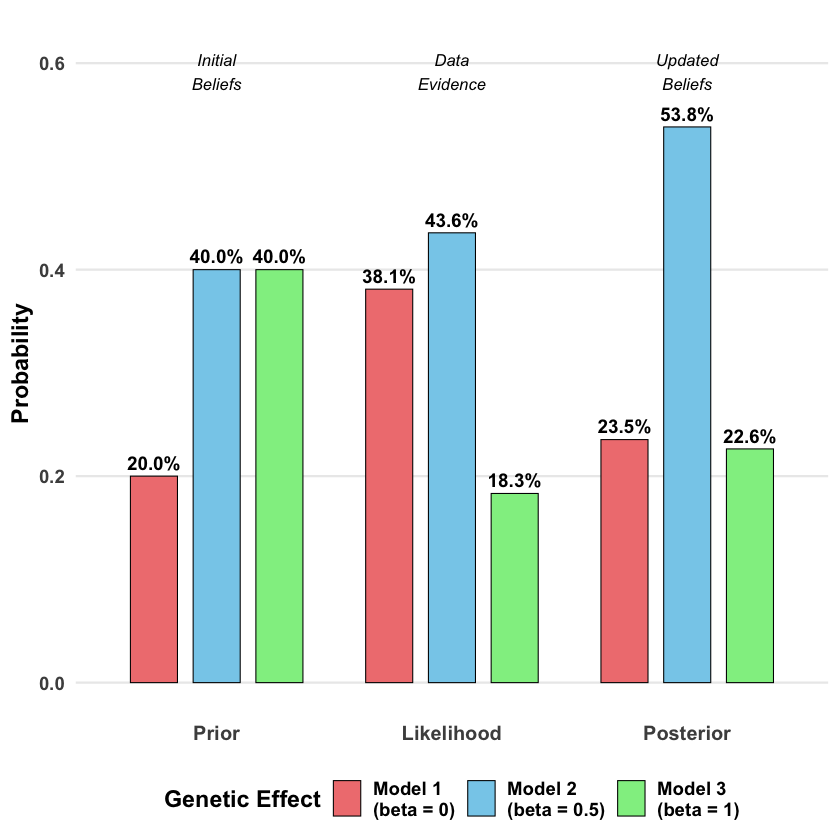

In [8]:
df_Bayes <- data.frame(
  Model = rep(paste0("Model ", 1:3, "\n(beta = ", beta_values, ")"), each = 3),
  Stage = rep(c("Prior", "Likelihood", "Posterior"), times = 3),
  Probability = c(
    # beta=0: prior, likelihood, posterior
    priors[1], likelihoods[1]/sum(likelihoods), posteriors[1],
    # beta=0.5: prior, likelihood, posterior  
    priors[2], likelihoods[2]/sum(likelihoods), posteriors[2],
    # beta=1.0: prior, likelihood, posterior
    priors[3], likelihoods[3]/sum(likelihoods), posteriors[3]
  )
)

# Set factor levels for proper ordering
df_Bayes$Stage <- factor(df_Bayes$Stage, levels = c("Prior", "Likelihood", "Posterior"))
df_Bayes$Model <- factor(df_Bayes$Model, levels = paste0("Model ", 1:3, "\n(beta = ", beta_values, ")"))

p_Bayes <- ggplot(df_Bayes, aes(x = Stage, y = Probability, fill = Model)) +
  geom_col(position = position_dodge(width = 0.8), width = 0.6, 
           color = "black", linewidth = 0.3) +
  geom_text(aes(label = scales::percent(Probability, accuracy = 0.1)), 
            position = position_dodge(width = 0.8), vjust = -0.5, 
            size = 4, fontface = "bold") +
  scale_fill_manual(values = c("lightcoral", "skyblue", "lightgreen"),
                    name = "Genetic Effect") +
  labs(
    y = "Probability",
    x = NULL,
    title = "Bayesian Update: From Prior Beliefs to Posterior Knowledge"
  ) +
  ylim(0, max(df_Bayes$Probability) * 1.15) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_blank(),
    axis.title.y = element_text(face = "bold"),
    axis.text.x = element_text(face = "bold", size = 12),
    axis.text.y = element_text(face = "bold"),
    legend.title = element_text(face = "bold"),
    legend.text = element_text(face = "bold"),
    legend.position = "bottom",
    panel.grid.minor = element_blank(),
    panel.grid.major.x = element_blank(),
    panel.background = element_rect(fill = "transparent", color = NA),
    plot.background = element_rect(fill = "transparent", color = NA)
  ) +
  annotate("text", x = 1, y = max(df_Bayes$Probability) * 1.1, 
           label = "Initial\nBeliefs", fontface = "italic", size = 3.5) +
  annotate("text", x = 2, y = max(df_Bayes$Probability) * 1.1, 
           label = "Data\nEvidence", fontface = "italic", size = 3.5) +
  annotate("text", x = 3, y = max(df_Bayes$Probability) * 1.1, 
           label = "Updated\nBeliefs", fontface = "italic", size = 3.5)

# Display the plot
print(p_Bayes)

In [9]:
ggsave("./figures/Bayes_rule.png", plot = p_Bayes,
       width = 10, height = 6, 
       bg = "transparent",
       dpi = 300)

The beauty of Bayes' rule is that it provides a principled way to incorporate both prior knowledge and new evidence. Our final belief (posterior) balances what we thought before seeing the data with what the evidence tells us.